### Exploring benchmark score structure and relationship to alignment

This is a very unprincipled and slightly meandering exploration of [Artificial Analysis' dataset](https://artificialanalysis
.ai/) describing performance of several frontier models across different benchmarks.

Much of this project was inspired by [this blog post](https://epoch
.ai/gradient-updates/benchmark-scores-general-capability-claudiness) from 
Epoch AI. There, they ran a PCA on benchmark data to identify two dimensions - general intelligence and something 
they call 'Claudiness' (high performance on agentic benchmarks, low on vision/math). One thing that bugged me a little 
about their work was just how sparse their dataset was, necessitating either substantial imputation or a noisy EM procedure (Epoch did the 
former, which I suspect may artificially decrease dimensionality). 

AA's dataset was much smaller (54 models across 12 benchmarks), but dense. 

My goal was to work from this to:
- Understand the structure of models' "capability structure" (basically replicating Epoch AI's analyses on this alternative dataset
- Explore how any latent structure might predict [MASK alignment leaderboard scores](https://scale.com/leaderboard/mask).

Main takeaways:
- Benchmark scores were _extremely_ highly correlated, and I only identified _one_ robust PC the captured almost 80% of variance, which seemed to correspond to general capability.
- Alignment could be predicted pretty well. But mainly from knowing the company behind the model, with predictions slightly improved by additionally knowing a model's general ability.
- There was a higher order component (PC3) that also seemed to improve prediction performance further beyond this. 
This relationship indicated that models exceling at agentic tasks (but worse at 
instruction following and maths) were more honest. But I'm skeptical of this result for several reasons. First, this 
component captured so little variance in the original data. And while in principle this doesn't exclude the 
possibility that it is still relevant for predicting honesty, these higher-order PCs are very susceptible to small 
changes to the original data (and may be most influenced by the kNN imputation I use to fill in missing data). 
Second, it seems like this relationship was largely driven by OpenAI's models, and didn't really apply to Anthropic 
models (the two companies dominating this dataset). While I did try to control somewhat for creator company, this PC might just reflect something specific to OpenAI's approach (specifically, that smaller openAI models might be less honest even after controlling for general ability).   
- Given all this, I guess the main takeaway for me is - honesty seems primarily driven by model creator, which other 
factors (such as how much it values performance on agentic tasks, or maths etc) possibly also influencing performance
. Either way, might be interesting to explore this space further but I think this dataset was a little too small (in 
both benchmark and model counts) to draw more meaningful and robust conclusions.


In [68]:
from config import DATA_PATH, PLOTS_PATH, ANALYSIS_OPS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from utils.analysis_fns import *
from utils.plotting import *

In [3]:
df = pd.read_csv(DATA_PATH)

meta_cols = ['model_name', 'model_key', 'slug', 'creator', 'release_date', 'core10_count']
honesty_cols = ['honesty_score', 'confidence_interval']

df_info = df[meta_cols]
df_honesty = df[honesty_cols]
df_bench = df.drop(columns=meta_cols + honesty_cols)

In [5]:
print(df_bench.shape)
df_bench.head()

(54, 12)


,gpqa,hle,scicode,livecodebench,mmlu_pro,aime_25,ifbench,lcr,terminalbench_hard,tau2,math_500,aime
0,0.656,0.048,0.376,0.394,0.803,0.210,0.440,0.483,0.212,0.500,0.850,0.223
1,0.772,0.103,0.403,0.473,0.837,0.563,0.483,0.607,0.212,0.547,0.947,0.487
2,0.796,0.117,0.398,0.636,0.873,0.733,0.537,0.337,0.311,0.705,0.982,0.757
3,0.683,0.040,0.373,0.449,0.837,0.380,0.454,0.443,0.273,0.523,0.934,0.407
4,0.777,0.096,0.400,0.655,0.842,0.743,0.547,0.647,0.311,0.646,0.991,0.773


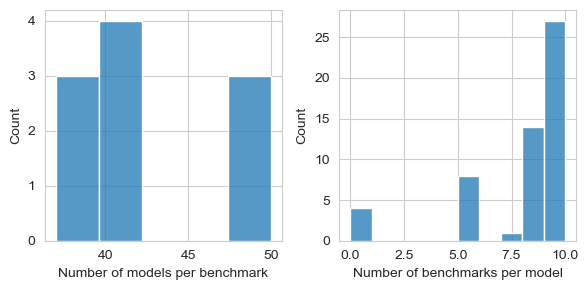

In [67]:
# data shouldn't be too sparse first look at what we're dealing with
models_per_bench = df_bench.iloc[:, 2:].notna().sum(axis=0)  # per column
benchs_per_model = df_bench.iloc[:, 2:].notna().sum(axis=1)  # per row

fig, ax = plt.subplots(1,2,figsize=(6, 3))
sns.histplot(ax=ax[0], data=models_per_bench)
ax[0].set(xlabel='Number of models per benchmark')

sns.histplot(ax=ax[1], data=benchs_per_model)
ax[1].set(xlabel='Number of benchmarks per model')

plt.tight_layout()  

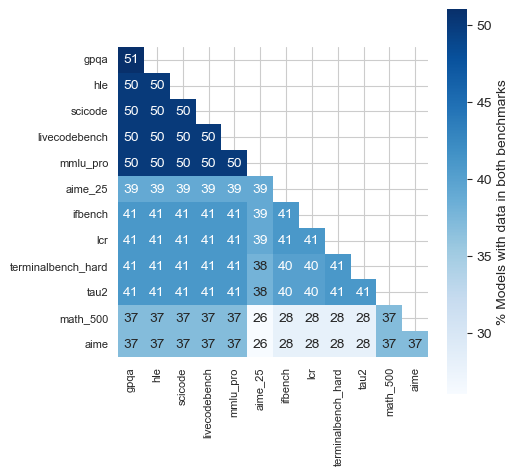

In [62]:
fig, ax = plt.subplots(figsize=(5,5))

overlap_matrix = df_bench.notna().astype(int).T @ df_bench.notna().astype(int)
sns.heatmap(ax=ax, 
            data=np.tril(overlap_matrix),
            mask=np.triu(np.ones_like(overlap_matrix, dtype=bool), k=1),
            cmap='Blues', 
            annot=True,
            cbar_kws={'label': '% Models with data in both benchmarks'},
            square=True,
            yticklabels=overlap_matrix.index,
            xticklabels=overlap_matrix.index)
ax.tick_params(axis='y', labelsize=8)  # Adjust size if needed
ax.tick_params(axis='x', labelsize=8, rotation=90)

<Axes: >

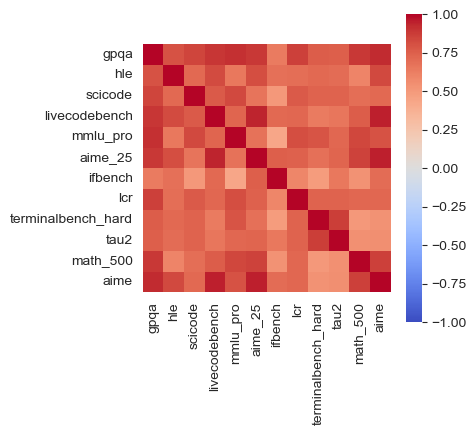

In [63]:
# plot correlation matrix
r = df_bench.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(data=r,
            vmin=-1, vmax=1,
            square=True,
            cmap='coolwarm', 
            xticklabels=df_bench.columns)

In [64]:
# kNN imputation to fill in missing
X_raw = df_bench.values
X_scaled = (X_raw - np.nanmean(X_raw, axis=0)) / np.nanstd(X_raw, axis=0)
X_full = knn_impute(X_scaled, n_neighbours=ANALYSIS_OPS['kNN_k'])

In [65]:
real_expVar, null_expVar = parallel_analysis(X_full, n_shuffles=100)

Number of components above 99% CI: 1


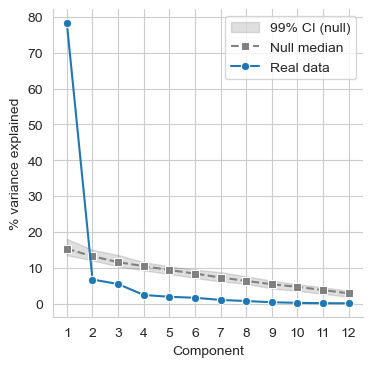

In [66]:
visualize_parallel_analysis_results(real_expVar, null_expVar, ci_size=99, convert_to_expvar=True)

Parallel analysis is indicating just one factor. But with such a dominant first dimension, this approach is almost 
certainly over-penalising components 2+. Visually, *maybe* PCs 2/3 could be capturing some meaningful variance?

I'll just take a look at the extracted components first:

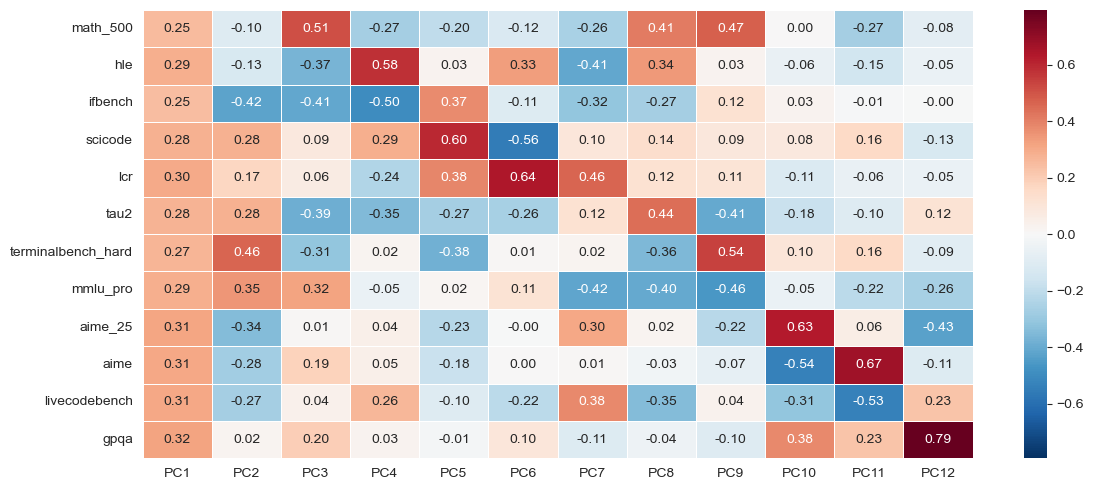

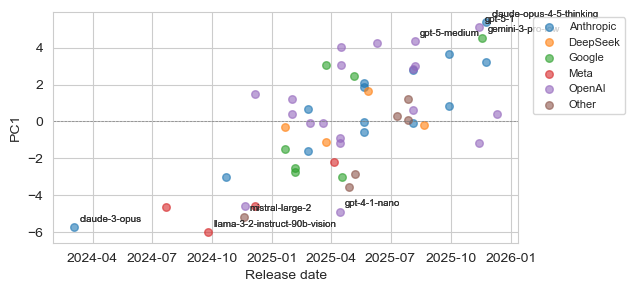

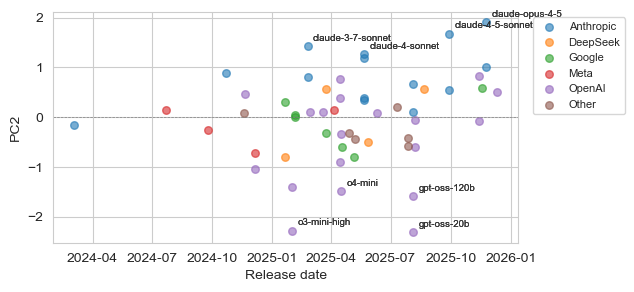

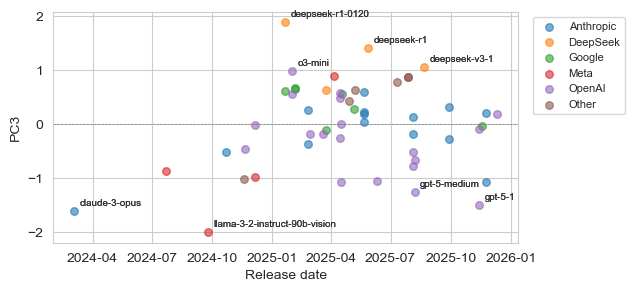

In [12]:
scores, components, exp_var = pca_scores(X_full)
loadings_heatmap(components.T, var_names=df_bench.columns)

# also look at first 3 pcs
for pc in range(3):
    plot_component_v_time(scores, pc, df_info=df_info, n_label=8)


In [13]:
real_var, null_var = pca_cv(X_full, n_splits=1000, holdout_frac=0.1)

Components above 95% CI: 1


<Axes: xlabel='Component', ylabel='Held-out variance explained'>

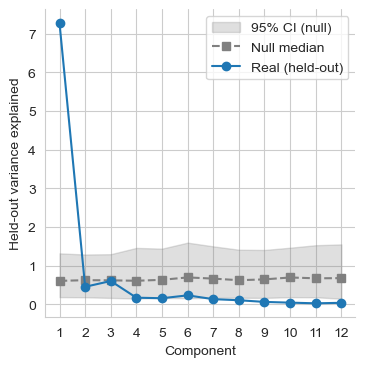

In [14]:
null_per_split = np.median(null_var, axis=2) # (n_splits, n_vars)
plot_cv_parallel(real_var, null_per_split, ci_size=95)

In [15]:
has_honesty = df_honesty['honesty_score'].notna()
y = df_honesty.loc[has_honesty, 'honesty_score'].values

In [16]:

def plot_scores_1d(values, df_info, has_mask, xlabel='Score', n_label=15):
    fig, ax = plt.subplots(figsize=(10, 2))

    rng = np.random.default_rng()
    jitter = rng.uniform(-0.2, 0.2, len(values))

    creator = df_info.loc[has_mask, 'creator'].reset_index(drop=True)
    top5 = creator.value_counts().head(5).index
    creator = creator.where(creator.isin(top5), other='Other')

    for name, idx in creator.groupby(creator).groups.items():
        ax.scatter(values[idx], jitter[idx], label=name, alpha=0.6, s=20)

    order = np.argsort(values)
    label_idx = np.concatenate([order[:n_label // 2], order[-(n_label - n_label // 2):]])
    for i in label_idx:
        ax.annotate(df_info.loc[has_mask, 'slug'].iloc[i], (values[i], jitter[i]),
                    fontsize=6, alpha=0.8, xytext=(0, 6), textcoords='offset points', ha='center')

    ax.set_xlabel(xlabel)
    ax.set_yticks([])
    ax.axvline(np.mean(values), color='grey', linewidth=0.5, linestyle='--')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    fig.tight_layout()
    return ax

In [17]:
X_base_empty = np.ones((has_honesty.sum(), 1))  # intercept only
X_base_pc1 = scores[has_honesty, :1]
results = {}
n_pcs = scores.shape[1]

# PC1 vs intercept
delta, null, p, m = permutation_test_loo(y, X_base_empty, X_base_pc1, n_perms=1000)
results[1] = {'delta': delta, 'p': p, 'beta': m.params[-1], 'model': m}
print('PC1: delta R2={:.3f} | p={:.3f} | beta={:.3f}'.format(delta, p, m.params[-1]), flush=True)

# PC2+ vs PC1
for k in range(1, n_pcs):
    X_extra = scores[has_honesty, k:k+1]
    delta, null, p, m = permutation_test_loo(y, X_base_pc1, X_extra, n_perms=1000)
    results[k+1] = {'delta': delta, 'p': p, 'beta': m.params[-1], 'model': m}
    print('PC{}: delta R2={:.3f} | p={:.3f} | beta={:.3f}'.format(k+1, delta, p, m.params[-1]), flush=True)

PC1: delta R2=0.217 | p=0.000 | beta=2.829
PC2: delta R2=0.014 | p=0.102 | beta=4.503
PC3: delta R2=0.161 | p=0.001 | beta=-8.875
PC4: delta R2=-0.023 | p=0.512 | beta=-6.230
PC5: delta R2=-0.007 | p=0.216 | beta=-5.075
PC6: delta R2=0.034 | p=0.054 | beta=-9.061
PC7: delta R2=-0.011 | p=0.251 | beta=4.938
PC8: delta R2=0.020 | p=0.089 | beta=-12.286
PC9: delta R2=-0.019 | p=0.411 | beta=8.955
PC10: delta R2=-0.015 | p=0.338 | beta=9.406
PC11: delta R2=-0.029 | p=0.657 | beta=-1.103
PC12: delta R2=-0.027 | p=0.604 | beta=-13.334



PC1
                                      gpqa  +0.321
                                   aime_25  +0.312
                                      aime  +0.307
                             livecodebench  +0.305
                                       lcr  +0.299

PC3
                                  math_500  +0.509
                                   ifbench  -0.411
                                      tau2  -0.386
                                       hle  -0.367
                                  mmlu_pro  +0.322


<Axes: >

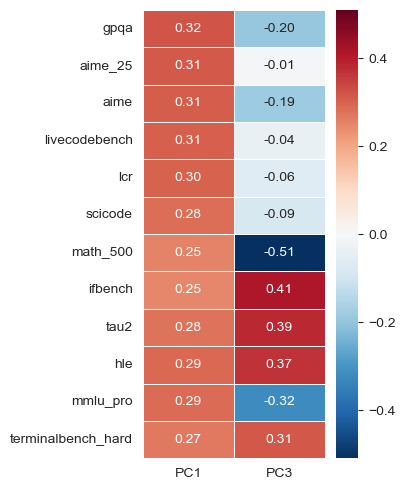

In [18]:
for k, r in results.items():
    if r['p'] < ANALYSIS_OPS['sigThresh']:
        top_loadings(components[k-1:k].T, df_bench.columns.tolist(), n_top=5, start_idx=k-1)
sig_pcs = [k for k, r in results.items() if r['p'] < ANALYSIS_OPS['sigThresh']]
sig_components = components[np.array(sig_pcs) - 1]  # (n_sig, n_vars)

# flip so positive loadings = predicts more honesty
signs = np.array([np.sign(results[k]['beta']) for k in sig_pcs]).reshape(-1, 1)
sig_components = sig_components * signs
loadings_heatmap(sig_components.T, df_bench.columns.tolist(),
                 comp_labels=[f"PC{k}" for k in sig_pcs])

In [19]:
creator = df_info.loc[has_honesty, 'creator'].copy()
top_creators = creator.value_counts().head(ANALYSIS_OPS['nTopCreators']).index
creator = creator.where(creator.isin(top_creators), other='Other')
creator_dummies = pd.get_dummies(creator, drop_first=False).drop(columns='Other').astype(float).values

results = {}

# PC1 vs creator baseline
delta, null, p, m = permutation_test_loo(y, creator_dummies, scores[has_honesty, :1], n_perms=1000)
results[1] = {'delta': delta, 'p': p, 'beta': m.params[-1], 'model': m}
print('PC1: delta R2={:.3f} | p={:.3f} | beta={:.3f}'.format(delta, p, m.params[-1]), flush=True)

# PC2+ vs creator + PC1
X_base = np.hstack([creator_dummies, scores[has_honesty, :1]])
for k in range(1, np.max(sig_pcs)):
    X_extra = scores[has_honesty, k:k+1]
    delta, null, p, m = permutation_test_loo(y, X_base, X_extra, n_perms=1000)
    results[k+1] = {'delta': delta, 'p': p, 'beta': m.params[-1], 'model': m}
    print('PC{}: delta R2={:.3f} | p={:.3f} | beta={:.3f}'.format(k+1, delta, p, m.params[-1]), flush=True)

PC1: delta R2=0.080 | p=0.001 | beta=1.813
PC2: delta R2=-0.021 | p=0.971 | beta=-2.314
PC3: delta R2=0.051 | p=0.003 | beta=-5.596


In [20]:
sig_pcs = [k for k, r in results.items() if r['p'] < ANALYSIS_OPS['sigThresh']]

<Axes: xlabel='PC1', ylabel='PC3'>

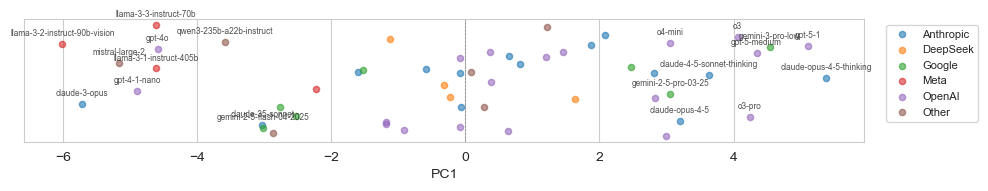

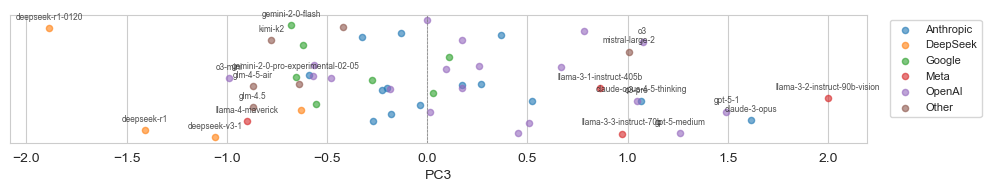

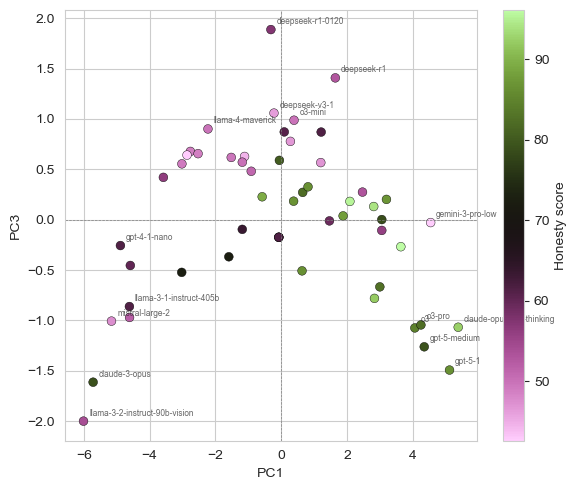

In [33]:
for pc in sig_pcs:
    sign = np.sign(results[pc]['beta'])
    plot_component_1d(scores * sign, pc - 1, df_info, comp_name=f"PC{pc}", n_label=20)
plot_pc_scatter_honesty(scores, 0, 2, y, df_info, has_honesty, n_label=10)

Interesting - so it looks like the negative side (less honest) is maybe dominated by reasoning models (deepseek-r1, o3-mini)? Honest side is mix of older and non-COT models (opus 3,llama-3-2-instruction-90b-vision). But it may also just be driven by a few deepseek models...


In [50]:
def make_creator_dummies(df_info, mask, n_top=None):
    if n_top is None:
        n_top = ANALYSIS_OPS['nTopCreators']
    creator = df_info.loc[mask, 'creator'].reset_index(drop=True)
    top = creator.value_counts().head(n_top).index
    creator = creator.where(creator.isin(top), other='Other')
    return pd.get_dummies(creator, drop_first=False).drop(columns='Other').astype(float).values

def test_pc_excluding_creator(creator_name, pc_idx, scores, y, df_info, has_mask):
    exclude = df_info.loc[has_mask, 'creator'].values == creator_name
    keep = ~exclude
    
    keep_mask = has_mask.copy()
    keep_mask.iloc[has_mask.values] &= ~exclude
    
    dummies = make_creator_dummies(df_info, keep_mask)
    X_base = np.hstack([dummies, scores[has_mask][keep, :1]])
    delta, null, p, m = permutation_test_loo(
        y[keep], X_base, scores[has_mask][keep, pc_idx:pc_idx+1])
    print(f"PC{pc_idx+1} without {creator_name}: LOO ΔR²={delta:.3f}, p={p:.4f}, beta={m.params[-1]:+.3f}")
    return delta, p, m

PC3 without DeepSeek: LOO ΔR²=0.051, p=0.0000, beta=-5.910


<Axes: xlabel='PC3 (no DeepSeek)'>

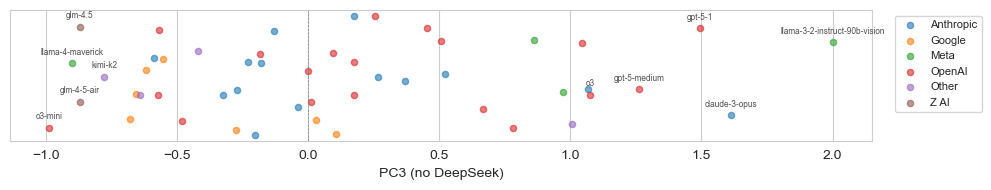

In [51]:
# test without DeepSeek
delta, p, m = test_pc_excluding_creator('DeepSeek', 2, scores, y, df_info, has_honesty)

# plot
keep = df_info.loc[has_honesty, 'creator'].values != 'DeepSeek'
sign = np.sign(results[3]['beta'])
df_info_sub = df_info.loc[has_honesty].iloc[keep].reset_index(drop=True)
scores_sub = scores[has_honesty][keep] * sign
plot_component_1d(scores_sub, 2, df_info_sub, comp_name="PC3 (no DeepSeek)", n_label=10)

In [71]:
# partial correlations per creator
df_check = pd.DataFrame({
    'pc1': scores[has_honesty, 0],
    'pc3': scores[has_honesty, 2],
    'honesty': y,
    'creator': df_info.loc[has_honesty, 'creator'].values
})
print(f"Correlations between PC1 and honesty")
for name, group in df_check.groupby('creator'):
    if len(group) >= 5:
        r = np.corrcoef(group['pc1'].values, group['honesty'].values)[0, 1]
        print(f"{name:>12s} (n={len(group):2d}): r={r:+.3f}")
        
print(f"Partial correlations between PC3 and honesty")
for name, group in df_check.groupby('creator'):
    if len(group) >= 5:
        pc3_resid = sm.OLS(group['pc3'].values, sm.add_constant(group['pc1'].values)).fit().resid
        hon_resid = sm.OLS(group['honesty'].values, sm.add_constant(group['pc1'].values)).fit().resid
        r = np.corrcoef(pc3_resid, hon_resid)[0, 1]
        print(f"{name:>12s} (n={len(group):2d}): partial r={r:+.3f}")
        

Correlations between PC1 and honesty
   Anthropic (n=14): r=+0.762
      Google (n= 7): r=+0.018
      OpenAI (n=19): r=+0.611
Partial correlations between PC3 and honesty
   Anthropic (n=14): partial r=-0.089
      Google (n= 7): partial r=-0.337
      OpenAI (n=19): partial r=-0.643


In [77]:
# without open AI
delta, p, m = test_pc_excluding_creator('OpenAI', 2, scores, y, df_info, has_honesty)


PC3 without OpenAI: LOO ΔR²=-0.010, p=0.8200, beta=-0.513


In [ ]:
n_oai = (df_info.loc[has_honesty, 'creator'].values == 'OpenAI').sum()
rng = np.random.default_rng(0)

p_values = []
for _ in range(100):
    keep = np.ones(len(y), dtype=bool)
    keep[rng.choice(len(y), size=n_oai, replace=False)] = False
    
    dummies = make_creator_dummies(df_info.loc[has_honesty].iloc[keep].reset_index(drop=True),
                                   pd.Series([True] * keep.sum()))
    X_base = np.hstack([dummies, scores[has_honesty][keep, :1]])
    _, _, p, _ = permutation_test_loo(y[keep], X_base, scores[has_honesty][keep, 2:3], n_perms=100)
    p_values.append(p)

p_values = np.array(p_values)
print(f"  Median p: {np.median(p_values):.3f}")

PC3 OpenAI only: LOO ΔR²=0.288, p=0.0000


<Axes: xlabel='PC3 (OpenAI only)'>

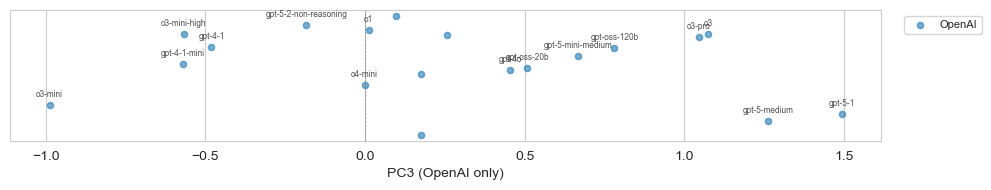

In [59]:
# OpenAI only
is_oai_only = df_info.loc[has_honesty, 'creator'].values == 'OpenAI'
y_oai = y[is_oai_only]
pc1_oai = scores[has_honesty][is_oai_only, :1]
pc3_oai = scores[has_honesty][is_oai_only, 2:3]

delta, null, p, m = permutation_test_loo(y_oai, pc1_oai, pc3_oai)
print(f"PC3 OpenAI only: LOO ΔR²={delta:.3f}, p={p:.4f}")

# visualise
sign = np.sign(results[3]['beta'])
df_info_oai = df_info.loc[has_honesty].iloc[is_oai_only].reset_index(drop=True)
plot_component_1d(scores[has_honesty][is_oai_only] * sign, 2, df_info_oai,
                  comp_name="PC3 (OpenAI only)", n_label=15)

In [27]:
bench_names = df_bench.columns.tolist()
X_full_h = X_full[has_honesty]

agentic = ['ifbench', 'tau2', 'hle', 'terminalbench_hard']
reasoning = ['math_500', 'mmlu_pro', 'gpqa', 'aime']

agentic_idx = [bench_names.index(b) for b in agentic]
reasoning_idx = [bench_names.index(b) for b in reasoning]

agentic_score = X_full_h[:, agentic_idx].mean(axis=1)
reasoning_score = X_full_h[:, reasoning_idx].mean(axis=1)
contrast = agentic_score - reasoning_score
g = scores[has_honesty, 0]

X_base = np.column_stack([creator_dummies, g])
X_extra = contrast.reshape(-1, 1)

delta, null, p, m = permutation_test_loo(y, X_base, X_extra)
print("Agentic vs Reasoning contrast: LOO dR2={:.3f} p={:.4f} beta={:+.3f}".format(delta, p, m.params[-1]))

Agentic vs Reasoning contrast: LOO dR2=0.046 p=0.0000 beta=+8.208


<Axes: title={'center': 'OpenAI'}, xlabel='PC1', ylabel='PC3'>

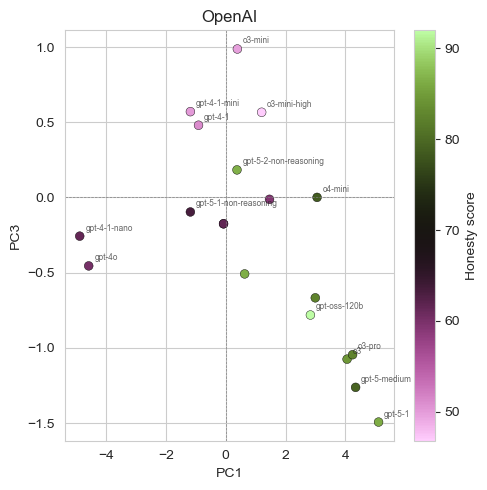

In [28]:
plot_pc_scatter_honesty(scores, 0, 2, y, df_info, has_honesty, creator_filter='OpenAI', n_label=10)